# Aris Tsilifonis sdi1700170 - Artificial Intelligence 2 (NLP with Deep Learning)

## 4th assignment - Text classification with bert for sentiment analysis
## Question B - C

The goal of the assignment was to train our bert model to answer questions.These questions were produced by wikipedia users and cover a wide variety of topics.Basically , we have to produce the results from that [paper -Table 3 ](https://arxiv.org/pdf/2004.03490.pdf).In this notebook , we train and test on squad datasets.

In [1]:
from pathlib import Path
import json
import torch
from torch.utils.data import DataLoader
import time

In [2]:
%%capture
!pip install  transformers>=4.5

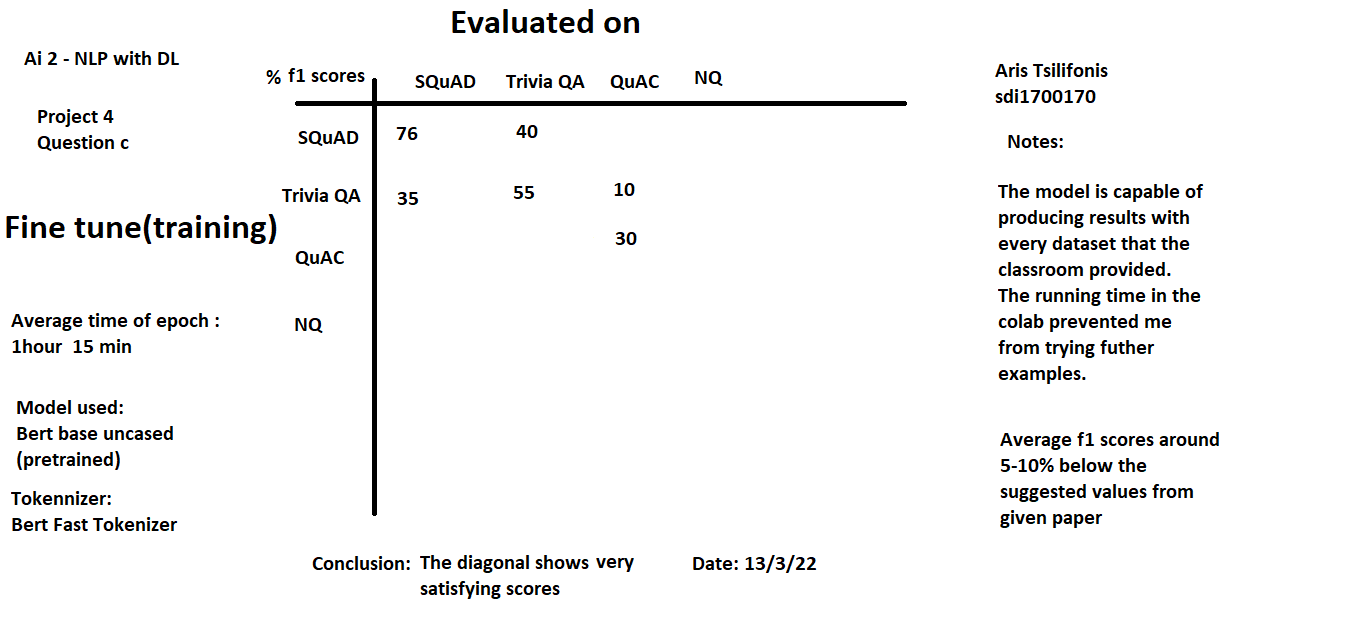

Load squad dataset from  given page : https://rajpurkar.github.io/SQuAD-explorer/

In [3]:
%%capture
!mkdir squadfiles
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squadfiles/dev-v2.0.json #squad train
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squadfiles/train-v2.0.json # squad evaluation

## Report
The diagonal seems to produce the best results

All dataset are converted to SQuAD format by the instrunctions given from that  [page](https://github.com/amazon-research/qa-dataset-converter) (basically running a script in linux to perform the operation)
Note: 

QuAC needs batch size 8 instead of 16 to run from this colab on the dataloaders (due to restrictions from CUDA device) 

Also the running time is referring to gpu time



Links to my drive regarding the other datasets that I used for testing:

[quac training](https://drive.google.com/file/d/1VsGs7VnP07_FZyEtpzC225HaErJztVbr/view?usp=sharing)
[quac test](https://drive.google.com/file/d/1Nm06MXe7Q2eN2g8FRq-b8t36P4QciUUn/view?usp=sharing)
[triviaqa training](https://drive.google.com/file/d/1QzFgRChv5-VdTLD7kxBl0O_je1qMzxbM/view?usp=sharing)
[triviaqa test](https://drive.google.com/file/d/15qOIeNtYYkRuT1uNt-wSKIA9H0aN4yLU/view?usp=sharing)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load question ,answers and context from squad train and validation dataset
In order to train the model on the data we need 
* the tokenized pairs of text and questions
* integers indicating the token positions that the answer begins and ends.

In [5]:
# Give the path for train data
# This path can be altered to point on another dataset  <-----------
path = Path('squadfiles/train-v2.0.json')

# Open .json file
with open(path) as filename:
    squad_dictionary = json.load(filename)

queries_list = []
answers_list = []
texts_list = []

# Search for each passage, its question and its answer
for data in squad_dictionary['data']:
    for paragraphs in data['paragraphs']:
        context = paragraphs['context']
        for qa in paragraphs['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts_list.append(context)
                queries_list.append(question)
                answers_list.append(answer)

train_txt, train_query, train_answer = texts_list, queries_list, answers_list

In [6]:
squad_dictionary['data'][0]

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
     'id': '56be85543aeaaa14008c9063',
     'is_impossible': False,
     'question': 'When did Beyonce start becoming popular?'},
    {'answers': [{'answer_start': 207, 'text': 'singing and danc

In [7]:
# Give the path for test data
# This path can be altered to point on another dataset  <-----------
path = Path('squadfiles/dev-v2.0.json')

# Open .json file
with open(path) as filename:
    squad_dictionary = json.load(filename)

queries_list = []
answers_list = []
texts_list = []

# Search for each passage, its question and its answer
for data in squad_dictionary['data']:
    for paragraphs in data['paragraphs']:
        context = paragraphs['context']
        for qa in paragraphs['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts_list.append(context)
                queries_list.append(question)
                answers_list.append(answer)

valid_txt, valid_query, valid_answer = texts_list, queries_list, answers_list

In [8]:
print(len(train_txt))
print(len(train_query))
print(len(train_answer))

86821
86821
86821


In [9]:
print("Text: ",train_txt[0])  
print("Query: ",train_query[0])
print("Answer: ",train_answer[0])

Text:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [10]:
train_txt[0]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [11]:
train_query[0:15]

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'When did Beyoncé rise to fame?',
 "What role did Beyoncé have in Destiny's Child?",
 'What was the first album Beyoncé released as a solo artist?',
 'When did Beyoncé release Dangerously in Love?',
 'How many Grammy awards did Beyoncé win for her first solo album?',
 "What was Beyoncé's role in Destiny's Child?",
 "What was the name of Beyoncé's first solo album?"]

In [12]:
train_answer[0:15]

[{'answer_start': 269, 'text': 'in the late 1990s'},
 {'answer_start': 207, 'text': 'singing and dancing'},
 {'answer_start': 526, 'text': '2003'},
 {'answer_start': 166, 'text': 'Houston, Texas'},
 {'answer_start': 276, 'text': 'late 1990s'},
 {'answer_start': 320, 'text': "Destiny's Child"},
 {'answer_start': 505, 'text': 'Dangerously in Love'},
 {'answer_start': 360, 'text': 'Mathew Knowles'},
 {'answer_start': 276, 'text': 'late 1990s'},
 {'answer_start': 290, 'text': 'lead singer'},
 {'answer_start': 505, 'text': 'Dangerously in Love'},
 {'answer_start': 526, 'text': '2003'},
 {'answer_start': 590, 'text': 'five'},
 {'answer_start': 290, 'text': 'lead singer'},
 {'answer_start': 505, 'text': 'Dangerously in Love'}]

In [13]:
print(len(valid_txt))
print(len(valid_query))
print(len(valid_answer))

20302
20302
20302


Squad answers are off by one or two characters, so we will fix that.

In [14]:
def add_end_index(answers, texts):
    for answer, text in zip(answers, texts):
        raw_text = answer['text']
        start_index = answer['answer_start']
        end_index = start_index + len(raw_text)

        # often squad answers are off by a one-two chars
        if text[start_index:end_index] == raw_text:
            answer['answer_end'] = end_index
        elif text[start_index-2:end_index-2] == raw_text:
            answer['answer_start'] = start_index - 2
            answer['answer_end'] = end_index - 2     # When the index is off by two chars
        elif text[start_index-1:end_index-1] == raw_text:
            answer['answer_start'] = start_index - 1
            answer['answer_end'] = end_index - 1     # When the index is off by one char

In [15]:
add_end_index(train_answer, train_txt)
add_end_index(valid_answer, valid_txt)

In [16]:
train_answer[0]

{'answer_end': 286, 'answer_start': 269, 'text': 'in the late 1990s'}

In [17]:
train_txt[0]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

Create fast bert tokenizer and get train and validation set as encoded

In [18]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encoded = tokenizer(train_txt, train_query, truncation=True, padding=True)
valid_encoded = tokenizer(valid_txt, valid_query, truncation=True, padding=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Convert answer strings to tokens

In [19]:
def chartoken_conversion(encoded, answerdict):
  end_pos = []
  start_pos = []
  for i in range(len(answerdict)):
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
      end_pos.append(encoded.char_to_token(i, answerdict[i]['answer_end'] - 1))
      start_pos.append(encoded.char_to_token(i, answerdict[i]['answer_start']))

      # if None, the answer passage has been truncated
      if end_pos[-1] is None:
          end_pos[-1] = tokenizer.model_max_length
      if start_pos[-1] is None:
          start_pos[-1] = tokenizer.model_max_length

  encoded.update({'start_position': start_pos, 'end_position': end_pos})

In [20]:
chartoken_conversion(train_encoded, train_answer)
chartoken_conversion(valid_encoded, valid_answer)

In [21]:
train_encoded[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [22]:
train_answer[0]

{'answer_end': 286, 'answer_start': 269, 'text': 'in the late 1990s'}

Define a custom dataset class

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class SquadData(Dataset):
    def __init__(self, encoded):
        self.encoded = encoded

    def __len__(self):
        return len(self.encoded.input_ids)

    def __getitem__(self, index):
        return {key: torch.tensor(value[index]) for key, value in self.encoded.items()}

train_data = SquadData(train_encoded)
valid_data = SquadData(valid_encoded)

Try to get gpu as device

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

Load Bert for question answering from tranformers library 

In [25]:
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Move model to device

In [26]:
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Get train and validation loaders of dataset.Also,we define the suitable optimizer for our model.

Learning rate 5e-5 gives the best results from my experiments
Also , I managed the best possible accuracy with batch of size 16.

In [27]:
from transformers import AdamW
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Define number of epochs.Moreover , we declared a scheduler that proved not efficient for our procedure.

In [28]:
from transformers import get_linear_schedule_with_warmup
EPOCHS = 2
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [29]:
def release_list(a):
   del a[:]
   del a

Some functions from evaluation script to get the f1 and exact scores.

In [30]:
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1
  

Training epoch. It is similar to the question A of the assignment although this time we have starting and ending position of tokens (refering to the place of the answer in the text data)

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import numpy as np
import pandas as pd
df = pd.DataFrame(train_answer)

def train_epoch(
  model, 
  data_loader,  
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  epoch_f1 = 0
  epoch_recall = 0
  epoch_accuracy = 0
  e = 0
  f=0
  g=0
  counter=0
  
  for d in data_loader:
    #load dataset to device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    start_positions = d['start_position'].to(device)
    end_positions = d['end_position'].to(device)
    

    outputs = model(
        input_ids, 
        attention_mask=attention_mask, 
        start_positions=start_positions, 
        end_positions=end_positions)
    
    #get the predicted outcome from the max value of the outputs
    #predicted outcome includes starting position and ending position of answer's token
    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)
    
    loss = outputs[0]
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    # Find the total loss
    losses.append(loss.item())
    
  return np.mean(losses)

In [32]:
print(valid_answer[0:15])
result = df[df.text == 'Alison Krauss']
len(result.text.values)

[{'text': 'France', 'answer_start': 159, 'answer_end': 165}, {'text': 'France', 'answer_start': 159, 'answer_end': 165}, {'text': 'France', 'answer_start': 159, 'answer_end': 165}, {'text': 'France', 'answer_start': 159, 'answer_end': 165}, {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87, 'answer_end': 117}, {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117}, {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256, 'answer_end': 283}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256, 'answer_end': 283}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256, 'answer_end': 283}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256, 'answer_end': 283}, {'text': 'Rollo', 'answer_start': 308, 'answer_end': 313}, {'text': 'Rollo', 'answer_start': 308, 'answer_end': 313}, {'text

1

Evaluation is similar to training but on this occasion we
* freeze the gradients
* we inverse the results of the tokens in order to get the textual answer
* we present another approach of predicting accuracy scores(precision).
The basic idea is to compare the predicted tokens of the model with the original set and then sum the similar values.In order to compare them , we sum the starting and ending position.So , if (starting + ending)[ORIGINAL] = (starting + ending)[PREDICTED] then we suppose that we have the same answer

In [33]:
df2 = pd.DataFrame(valid_answer)
def eval_model(
  model, 
  data_loader,
  device,  
  n_examples
):
  model.eval()
  losses = []
  counter = 0
  e = 0
  acc = 0
  f = 0
  g = 0
  f1 = 0
  exact = 0
  #freeze gradients
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      start_positions = d['start_position'].to(device)
      end_positions = d['end_position'].to(device)

      outputs = model(
          input_ids, 
          attention_mask=attention_mask, 
          start_positions=start_positions, 
          end_positions=end_positions)
      
      start_pred = torch.argmax(outputs['start_logits'], dim=1)
      end_pred = torch.argmax(outputs['end_logits'], dim=1)
      
      #convert tensors to numpy arrays
      em_score = 0
      f1_score = 0
      s=np.array([t.cpu().numpy() for t in start_pred])
      u=np.array([t.cpu().numpy() for t in end_pred])
      v=np.array([t.cpu().numpy() for t in start_positions])
      w=np.array([t.cpu().numpy() for t in end_positions])

      for i in range(0,len(start_pred)):
        #get the specific item of the numpy arrays and convert it to int
        x = int(s[i].item())
        y = int(u[i].item())+1
        z = int(start_positions[i])
        w = int(end_positions[i])+1
        
        #inverse transform
        #token to strings 
        #we need to traverse the correct set in input_ids
        input_idx = input_ids[i].tolist()
        batch_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_idx[x:y]))

        true_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_idx[z:w])) 

        #some experimentation with true answers 
        #result = df[df.answer_start == v[i]]
        #true_answer = result.text.values[0]

        #compute scores of every batch with script functions
        k = compute_exact(batch_answer, true_answer)
        l = compute_f1(batch_answer, true_answer)
        em_score+= k
        f1_score+= l
        #print(f'{k} {l}')

      #precision scores
      a = start_pred + end_pred
      b = start_positions + end_positions
      c = torch.eq(a, b).sum()
      del s
      del u
      del v
      del w

      #normalize scores
      d = (c.item()/len(a))*100
      em_score = (em_score/len(a))*100
      f1_score = (f1_score/ len(a))*100
      counter+=1
      e += d
      f += f1_score
      g += em_score
      #print(f'{f1_score} {em_score}')
      em_score = 0
      f1_score = 0

      loss = outputs[0]
      
      # Find the total loss
      losses.append(loss.item())
  #Mean values of scores
  acc = e/counter
  f1 = f/counter
  exact = g/counter

  return acc,f1,exact,np.mean(losses)

In [34]:
%%time
from collections import defaultdict
history = defaultdict(list)
#min value initialization
best_loss = 20000

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_loss = train_epoch(
    model,
    train_loader,     
    optimizer, 
    device, 
    scheduler, 
    len(train_loader)
  )

  print(f'Train loss {train_loss}')

  prec,f1,exact,val_loss = eval_model(
    model,
    valid_loader, 
    device, 
    len(valid_loader)
  )

  print(f'Val   loss {val_loss} Val Precision {prec} f1 {f1} exact {exact}')

  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  if val_loss < best_loss:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_loss = val_loss

Epoch 1/2
----------
Train loss 1.3235834952006578
Val   loss 1.1596047965629164 Val Precision 56.36257458065969 f1 76.15698023009514 exact 61.761932905549926
Epoch 2/2
----------
Train loss 0.8383591861735398
Val   loss 1.2176821801350566 Val Precision 55.468310255544296 f1 75.74710493659674 exact 60.89229426995385
CPU times: user 2h 38min 6s, sys: 8min 51s, total: 2h 46min 57s
Wall time: 2h 46min 13s


As we see precision scores are quite close to the one's at the paper. We achieve 76% f1 score on the evaluation set which is quite satisfying.
We try to prevent overfit by saving the best state of the model , which is determined by the least loss value in the evaluation of validation set.

Plot of training and validation loss

As we see, in second epoch the training loss is becoming less than the validation loss, which is a sign of overfit and means that we cant improve the validation accuracy with more epochs. 

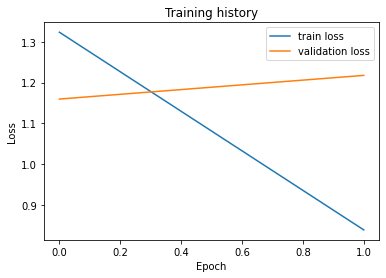

In [35]:
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [36]:
from transformers.data.metrics.squad_metrics import compute_predictions_logits

Download evaluation script from given page

In [37]:
!wget https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/ -O squadfiles/evaluation-v2.0.py

--2022-03-12 20:02:49--  https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
Resolving worksheets.codalab.org (worksheets.codalab.org)... 13.68.212.115
Connecting to worksheets.codalab.org (worksheets.codalab.org)|13.68.212.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/x-python]
Saving to: ‘squadfiles/evaluation-v2.0.py’

squadfiles/evaluati     [ <=>                ]  10.30K  --.-KB/s    in 0s      

2022-03-12 20:02:50 (57.7 MB/s) - ‘squadfiles/evaluation-v2.0.py’ saved [10547]



Testing a command to see how the script behaves. As you see, we need predictions to a json format that has not been created.We opted to copy only some functions and not the entire script.This approach boosted my productivity.

In [38]:
!python squadfiles/evaluation-v2.0.py squadfiles/dev-v2.0.json predictions.json --na-prob-file null_odds.json

Traceback (most recent call last):
  File "squadfiles/evaluation-v2.0.py", line 276, in <module>
    main()
  File "squadfiles/evaluation-v2.0.py", line 235, in main
    with open(OPTS.pred_file) as f:
FileNotFoundError: [Errno 2] No such file or directory: 'predictions.json'


In [39]:
%run squadfiles/evaluation-v2.0.py -h

usage: Official evaluation script for SQuAD version 2.0. [-h]
                                                         [--out-file eval.json]
                                                         [--na-prob-file na_prob.json]
                                                         [--na-prob-thresh NA_PROB_THRESH]
                                                         [--out-image-dir out_images]
                                                         [--verbose]
                                                         data.json pred.json

positional arguments:
  data.json             Input data JSON file.
  pred.json             Model predictions.

optional arguments:
  -h, --help            show this help message and exit
  --out-file eval.json, -o eval.json
                        Write accuracy metrics to file (default is stdout).
  --na-prob-file na_prob.json, -n na_prob.json
                        Model estimates of probability of no answer.
  --na-prob-thresh NA_PROB_THR

<Figure size 432x288 with 0 Axes>

Load best state of the model in order to test it in a portion of the testing set.In this way, we get a clearier idea of how the model behaves in the given set.

In [40]:
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
model.load_state_dict(torch.load('best_model_state.bin'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

<All keys matched successfully>

Function that reviews the question answering mechanism.We pass a text , the questions about that text and their specific answers to he model. We expect the outcome of it to determine its performance scores.

In [41]:
def qa(question,answer_text,model,tokenizer,trueans):
  inputs = tokenizer.encode_plus(question, answer_text, add_special_tokens=True, return_tensors="pt")
  input_ids = inputs["input_ids"].tolist()[0]

  text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  outputs = model(**inputs)
  answer_start_scores=outputs.start_logits
  answer_end_scores=outputs.end_logits

  answer_start = torch.argmax(
      answer_start_scores
  )  # Get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

  
  # Combine the tokens in the answer and print it out.""
  answer = answer.replace("#","")

  em_score = compute_exact(answer, trueans)
  f1_score = compute_f1(answer, trueans)
  print('Answer: ' + answer +  '\nTrue: '+ trueans)
  print(f'Exact match: {em_score}')
  print(f'F1 score: {f1_score}\n')
  return answer

As we see in the example below , we get pretty similar f1 accuracy with the total accuracy of evaluation set(around 75%).It is a good way to validate our results by experimenting with a stand-alone example.

In [42]:
context = """Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, 
          songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing 
          and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. 
          Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. 
          Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, 
          earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy"."""


questions = ['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'When did Beyoncé rise to fame?',
 "What role did Beyoncé have in Destiny's Child?",
 'What was the first album Beyoncé released as a solo artist?',
 'When did Beyoncé release Dangerously in Love?',
 'How many Grammy awards did Beyoncé win for her first solo album?',
 "What was Beyoncé's role in Destiny's Child?",
 "What was the name of Beyoncé's first solo album?"]

answers = ['in the late 1990s',
 'singing and dancing',
 '2003',
 'Houston, Texas',
 'late 1990s',
 "Destiny's Child",
 'Dangerously in Love',
 'Mathew Knowles',
 'late 1990s',
 'lead singer',
 'Dangerously in Love',
 '2003',
 'five',
 'lead singer',
 'Dangerously in Love'
 ]

for question, answer in zip(questions, answers):
  qa(question,context,model,tokenizer,answer)

Answer: late 1990s
True: in the late 1990s
Exact match: 0
F1 score: 0.8

Answer: singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child
True: singing and dancing
Exact match: 0
F1 score: 0.23076923076923078

Answer: late 1990s
True: 2003
Exact match: 0
F1 score: 0

Answer: houston
True: Houston, Texas
Exact match: 0
F1 score: 0.6666666666666666

Answer: 1990s
True: late 1990s
Exact match: 0
F1 score: 0.6666666666666666

Answer: destiny's child
True: Destiny's Child
Exact match: 1
F1 score: 1.0

Answer: dangerously in love
True: Dangerously in Love
Exact match: 1
F1 score: 1.0

Answer: mathew knowles
True: Mathew Knowles
Exact match: 1
F1 score: 1.0

Answer: late 1990s
True: late 1990s
Exact match: 1
F1 score: 1.0

Answer: lead singer of r & b girl - group destiny's child
True: lead singer
Exact match: 0
F1 score: 0.3636363636363636

Answer: dangerously in love
True: Dangerously in Love
Exact match: 1
F1 score

In [43]:
context = """Angelos Poulis was born on 8 April 2001 in Nicosia, Cyprus. He is half Cypriot and half Greek. 
            He is currently studying at the Department of Informatics and Telecommunications of the University of Athens in Greece. 
            His scientific interests are in the broad field of Artificial Intelligence and he loves to train neural networks! 
            Okay, I'm Angelos and I'll stop talking about me right now."""

questions = ["When did Angelos born?",
             "In what university is Angelos studying now?",
             "What is Angelos' nationality?",
             "What are his scientific interests?",
             "What I will do right now?"]

answers = ["8 April 2001", "University of Athens", 
           "half Cypriot and half Greek", "Artificial Intelligence", 
           "stop talking about me"]

for question, answer in zip(questions, answers):
  qa(question,context,model,tokenizer,answer)

Answer: 8 april 2001
True: 8 April 2001
Exact match: 1
F1 score: 1.0

Answer: university of athens
True: University of Athens
Exact match: 1
F1 score: 1.0

Answer: greek
True: half Cypriot and half Greek
Exact match: 0
F1 score: 0.33333333333333337

Answer: artificial intelligence
True: Artificial Intelligence
Exact match: 1
F1 score: 1.0

Answer: stop talking about me
True: stop talking about me
Exact match: 1
F1 score: 1.0

